# Automatic E-mail Categorization

This project attempts to accurately classify e-mails into folders based on e-mail content. This is a Natural Language Processing challenge that uses a Bag-of-words model to convert text documents into numerical feature vectors. Two standard classifiers were trained and tested on the email foldering task. 

Undoubtedly, categorizing e-mails based on the content can pose so many challenges.  In reality, there is a constant stream of new information being passed through e-mails each day and much of what we learn from previous e-mails may not be able to tell us much about future e-mails.  E-mail threads will branch off onto new topics, and each user organizes their e-mails in different ways.  As a result, the user ididiosyncrasies will affect the performance of any standard classifiers.

I found this to be an interesting angle to tackle the Enron Corpus, the largest public domain database in the world containing real-world email messages.  The version used contains over 500,000 emails from about 150 users, mostly senior management at Enron. You can visit [here](https://en.wikipedia.org/wiki/Enron_scandal) to learn more about the Enron scandal.  You can get a copy of the dataset [here](https://www.cs.cmu.edu/~./enron/).  

Benchmark results and for this project can be found [here](http://scholarworks.umass.edu/cgi/viewcontent.cgi?article=1217&context=cs_faculty_pubs).  Bekkerman et al. (Ron Bekkerman, Andrew McCallum and Gary Huang). *Automatic Categorization of Email into Folders: Benchmark Experiments on Enron and SRI Corpora*

##  Exploring the Enron Emails Dataset

In [847]:
import pandas as pd
pd.set_option("display.max_rows", 999)
pd.set_option('max_colwidth',100)
import numpy as np
from IPython.display import display

filepath = "data/emails.csv"
# Read the data into a pandas dataframe called emails
emails = pd.read_csv(filepath)
emails =  emails.iloc[:20000]
print("Successfully loaded {} rows and {} columns!".format(emails.shape[0], emails.shape[1]))
# Print column names
print(emails.columns)
# Store column headers 
headers = [header for header in emails.columns]
# Print the first 5 rows of the dataset
print(display(emails.head()))

Successfully loaded 20000 rows and 2 columns!
Index([u'file', u'message'], dtype='object')


,file,message
0,allen-p/_sent_mail/1.,"Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>\nDate: Mon, 14 May 2001 16:39:00 -0700..."
1,allen-p/_sent_mail/10.,"Message-ID: <15464986.1075855378456.JavaMail.evans@thyme>\nDate: Fri, 4 May 2001 13:51:00 -0700 ..."
2,allen-p/_sent_mail/100.,"Message-ID: <24216240.1075855687451.JavaMail.evans@thyme>\nDate: Wed, 18 Oct 2000 03:00:00 -0700..."
3,allen-p/_sent_mail/1000.,"Message-ID: <13505866.1075863688222.JavaMail.evans@thyme>\nDate: Mon, 23 Oct 2000 06:13:00 -0700..."
4,allen-p/_sent_mail/1001.,"Message-ID: <30922949.1075863688243.JavaMail.evans@thyme>\nDate: Thu, 31 Aug 2000 05:07:00 -0700..."


None


Numpy and pandas were imported, then the csv file containing the e-mails was read into a dataframe called **`emails`**.  The reading may take a while due to the size of the file.  Next, the shape of the dataset, column names and a sample of five rows within the dataset were printed.  There are 517,401 rows and 2 columns.  

**`file`** - contains the original directory and filename of each email. The root level of this path is the employee (surname first followed by first name initial) to whom the emails belong. 

**`message`** - contains the email text

### A sample e-mail

Here is a sample of the standard e-mail found in the data.  It contains a list of headers and a message body.  Note that there is a header label called "Mime-Version", which signifies that the e-mails in this dataset are MIME formatted.  MIME stands for Multipurpose Internet Mail Extensions and virtually all human-written email is transmitted in MIME format.  Python has a built in [MIME handling package](https://docs.python.org/2/library/email.html) and this is what will be used to dissect the data needed out of each e-mail.

In [698]:
print(emails.loc[0]["message"])

Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Here is our forecast

 


### Features and Label

From each e-mail, we can extract headers such as `To`, `Subject`, `From` and the message body to use as features.  The `X-Folder` header will be our label.  It  contains the path to each folder. 

Essentially, we are taking several features of the e-mail to classify the folder in which the e-mail was stored.  Note though that all of the headers are in strings and we will need to be able to process these headers for the computer to interpret them.  The [Bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) model will be used to take text documents, such as our features and output a numerical representation as a feature vector.  

The label, `X-folder` contains several folders and subfolders.  To better visualize all the end nodes of these folders, it would make sense to extract them from the entire filepath and append it to our existing `emails` dataframe.  

### Extract headers

In [848]:
import email

def insert_value(dictionary, key, value):
    if key in dictionary:
        values = dictionary.get(key)
        values.append(value)
        dictionary[key] = values
    else:
        dictionary[key] = [value]
    return dictionary

def get_headers(df, header_names):
    headers = {}
    messages = df["message"]
    for message in messages:
        e = email.message_from_string(message)
        for item in header_names:
            header = e.get(item)
            insert_value(dictionary = headers, key = item, value = header) 
    print("Successfully retrieved header information!")
    return headers
header_names = ["Date", "Subject", "X-Folder", "X-From", "X-To"]    
headers = get_headers(emails, header_names)

Successfully retrieved header information!


###  Extract Message Body

Here we extract the message body using and add it as a new column called **`Message_Body`** to **`emails`**

In [849]:
def get_messages(df):
    messages = []
    for item in df["message"]:
        # Return a message object structure from a string
        e = email.message_from_string(item)    
        # get message body  
        message_body = e.get_payload()
        # lower case messages
        message_body = message_body.lower()
        messages.append(message_body)
    print("Successfully retrieved message body of e-mails!")
    return messages
msg_body = get_messages(emails)
# add new column with message body content
emails["Message-Body"] = msg_body

Successfully retrieved message body of e-mails!


### Get Employee names

A sample of unique values from the `X-From` column shows that there are some e-mails sent from non-employees, such as, bloomberg.com, earnings.com, nytimes.com.  These are sites to other companies, so I am not sure how to interpret this.  What I can infer is that it would be suitable to use the employee names found in the `file` column of the `emails` dataframe.  It contains unique employee names.  It is a part of a string with other info so we will just have to extract the names and append it to `emails`.  We will use the employee names to filter the data for records per employee.

In [850]:
x_from = pd.DataFrame(headers["X-From"], columns = ["X-From"])
print len(x_from["X-From"].unique())
print(x_from.iloc[:1000]["X-From"].unique())
if "X-From" not in emails.columns:
    emails = pd.concat([emails, x_from], axis = 1, join = 'inner')

1708
['Phillip K Allen' 'Ina Rangel'
 'Multex Investor <1.11913372.-2@multexinvestornetwork.com>'
 '"Bloomberg.com" <messenger@ecm.bloomberg.com>'
 '"Arthur O\'Donnell" <aod@newsdata.com>' 'critical.notice@Enron.com'
 'market-reply@LISTSERV.DOWJONES.COM' 'Rebecca W Cantrell'
 '"Earnings.com" <webmaster@earnings.com>' 'Paul Kaufman'
 '"Y-Life to Go" <yild@zdemail.zdlists.com>'
 'bounce-news-932653@lists.autoweb.com' 'Public Relations'
 'Stephanie Miller' 'Tracy L Arthur' 'Sarah Novosel' 'bobregon@bga.com'
 'subscriptions@intelligencepress.com' 'Tim Heizenrader'
 'rob_tom@freenet.carleton.ca (Robert W. Tom)' 'CALXA@aol.com'
 'Energy Insight Editor <EI_editor@FTENERGY.COM>' 'billc@greenbuilder.com'
 'Frank Hayden' '"Matt" <matt@fastpacket.net>'
 'The HCFR <jfreeman@ssm.net>' 'owner-strawbale@crest.org' 'Kim Ward'
 'GrenSheltr@aol.com' 'Yahoo! Delivers <yahoo-delivers@yahoo-inc.com>'
 '"Performance Evaluation Process (PEP)" <perfmgmt@enron.com>'
 '"NYTimes.com" <announce@inbox.nytimes.com>

In [851]:
def add_name(df, column, labels):
    new_data = {}
    for item in df[column]: 
        # Split string into tokens
        tokens = item.split('/')
            # Get employee name (eg."allen-p")
        for i in range(0, len(labels)):
            value = tokens[i]
            key = labels[i]
            new_data = insert_value(new_data, key, value)
            # Get folder (eg."_sent_mail")         
    for key, value in new_data.items():
        df[key] = pd.Series(value)
    print("Successfully added new column!")
    return df
emails = add_name(df = emails, column = "file", labels = ["employee"])

Successfully added new column!


### A quick look at the folders

Here we print a sample of randomly selected folders from a newly created `folders` dataframe.  Take a look at the end node, or the last folder in each row and you will notice that there are more than two folder options in use.  The Enron employees stored their e-mails across several folders and as such, this looks like a [**multiclass classification**](https://en.wikipedia.org/wiki/Multiclass_classification) problem.  For this project, the one-versus-all method will be used to tackle this problem.  In a one-versus-all method, we are essentially doing a binary classification for n number of classes.  Therefore n number of models will be trained for each class based on the number of folders used by each employee. 

In [852]:
folders = pd.DataFrame(headers["X-Folder"], columns = ["Folder"])
# Concatenate folders to emails dataframe
emails = pd.concat([emails, folders], axis = 1, join = 'inner')

In [855]:
print(emails["Folder"].sample(7))

14381         \Eric_Bass_Dec2000\Notes Folders\Discussion threads
7997              \Harry_Arora_Jan2002\Arora, Harry\Deleted Items
3561                \John_Arnold_Jun2001\Notes Folders\'sent mail
1793     \Phillip_Allen_June2001\Notes Folders\Discussion threads
13715            \EBASS (Non-Privileged)\Bass, Eric\Deleted Items
17188                       \Eric_Bass_Dec2000\Notes Folders\Sent
16297               \EBASS (Non-Privileged)\Bass, Eric\Sent Items
Name: Folder, dtype: object


In [856]:
def add_other_headers(df, header_list):
    for label in header_list:
        df_new = pd.DataFrame(headers[label], columns = [label])
        if label not in df.columns:
            df = pd.concat([df, df_new], axis = 1)
    return df
remaining_headers = ["Date", "Subject", "X-To", "X-From"]
emails = add_other_headers(df = emails, header_list = remaining_headers)
print("Here is the emails dataframe after appending all the relevant headers")
print(display(emails.iloc[:1]))

Here is the emails dataframe after appending all the relevant headers


,file,message,Message-Body,X-From,employee,Folder,Date,Subject,X-To
0,allen-p/_sent_mail/1.,"Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>\nDate: Mon, 14 May 2001 16:39:00 -0700...",here is our forecast\n\n,Phillip K Allen,allen-p,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail","Mon, 14 May 2001 16:39:00 -0700 (PDT)",,Tim Belden <Tim Belden/Enron@EnronXGate>


None


### Data Cleaning

Here are the list of things that needs to be performed on the data:

* Convert `date` column to datetime
* Remove non-topical folders
* Remove folders containing too few e-mails (less than 2)
* Select employees with over 1000 e-mails 
* Drop rows with missing values
* Encode class labels
* **Bag-of-words** model
    * Tokenization
    * Remove unwanted characters from the `message`, `Subject`, `X-To` and `X-From` columns
    * Assemble matrices
    * Count tokens
    * Remove stop-words

In [857]:
# Convert date column to datetime 
emails["Date"] = pd.to_datetime(emails["Date"])
print(emails.iloc[:1]["Date"])

0   2001-05-14 23:39:00
Name: Date, dtype: datetime64[ns]


### Preprocess Folders

The `X-Folder` column contains several folders and subfolders that we do not need.  These include none-topical folders, which refer to folders that hold e-mails regardless of content (inbox, sent, trash, drafts are just a few).  These will be removed because it is pretty hard to accurately train a classifier using them. Below, you will find a list of all the end node folders and the number of e-mails stored in each.  Notice that a large portion of e-mails are stored in the automatically created folders of an e-mail application, such as:
* all_documents
* discussion_threads
* sent
* deleted_items
* inbox
* sent_items
* notes_inbox
* _sent_mail
* calendar  

In [858]:
def preprocess_folder(data):
    folders = []
    for item in data:
        if item is None or item is '':
            folders.append(np.nan)
        else:
            item = item.split("\\")[-1]
            item = item.lower()
            folders.append(item)
    print("Folder cleaned!")
    return folders      
emails["Folder"] = preprocess_folder(emails["Folder"])   

Folder cleaned!


In [859]:
# Folder count
print(emails["Folder"].value_counts())[:30]

all documents           4481
discussion threads      2917
'sent mail              2877
sent                    2750
deleted items           2573
sent items              1415
inbox                    987
notes inbox              858
24 hour                  229
savedmail                 90
california                70
saved mail                67
ect admin                 56
cinergy index             51
interviews                49
letters                   45
internet                  34
miso                      29
calendar                  27
personal                  25
imagesmoviessound         16
bmc                       16
jokes                     15
vermont yankee nuke       15
tasks                     14
compaq                    13
e_services                13
hp                        13
continental airlines      12
memo's                    10
Name: Folder, dtype: int64


### Remove Non-topical Folders

In [860]:
# Folders we can filter out
unwanted_folders = ["all documents", "deleted items", "discussion threads", "sent", "deleted Items", "inbox",
                   "sent items", "'sent mail", "untitled", "notes inbox", "junk file", "calendar"]

# A new dataframe without non-topical folders
emails = emails.loc[~emails['Folder'].isin(unwanted_folders)]
print(emails["Folder"].value_counts())[:15]

24 hour                229
savedmail               90
california              70
saved mail              67
ect admin               56
cinergy index           51
interviews              49
letters                 45
internet                34
miso                    29
personal                25
imagesmoviessound       16
bmc                     16
jokes                   15
vermont yankee nuke     15
Name: Folder, dtype: int64


### Remove folders that contain just one e-mail

We also remove folders that contain one e-mail because such folders would not be significant for training our models later on.  Also, we can also infer that such folders were created but unused.

In [861]:
email_count = dict(emails["Folder"].value_counts())
small_folders = [key for key, val in email_count.items() if val < 2]
emails = emails.loc[~emails['Folder'].isin(small_folders)]
print("Folders with less than 2 e-mails removed!\nThis is a list of the 20 smallest folders\n")
print(emails["Folder"].value_counts())[-20:]

Folders with less than 2 e-mails removed!
This is a list of the 20 smallest folders

requisite             4
kinko's               4
expense acct.         4
gri timesheets        4
receipts              3
2000 conference       3
etol                  3
mdea                  3
sap                   3
vulcan signs          3
drafts                3
ebs                   3
bristol babcock       2
colleen koenig        2
corestaff             2
pcc values            2
nepco europe          2
entex                 2
uplifting messages    2
bridge                2
Name: Folder, dtype: int64


### Visualize folders by size

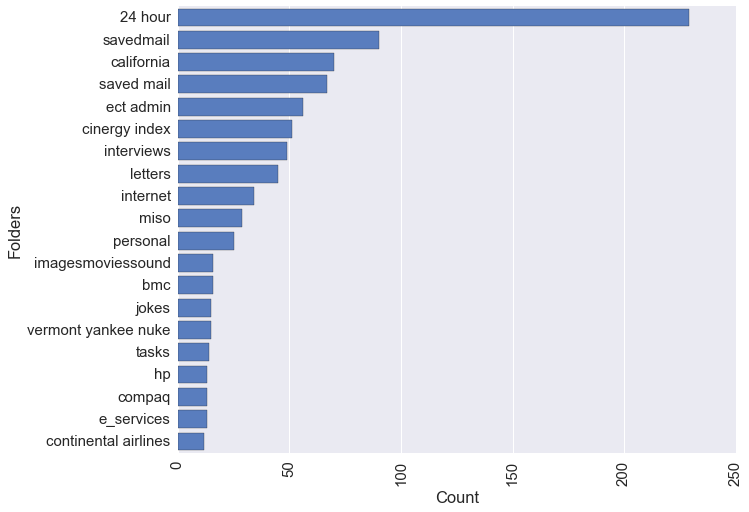

In [1008]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# dataframe containing counts of every word in the emails dataframe
email_count = emails["Folder"].value_counts()
indices = email_count.index
count = pd.DataFrame(email_count, columns = ["Folder"])
count["Folder Names"] = indices
#print count.head()

def barplot(df, X, Y, figsize, color, orient, ylabel, xlabel, font_scale, rotation):
    f, ax = plt.subplots(figsize=figsize)
    sns.set_color_codes("muted")
    sns.barplot(x = X, y = Y, data = df, color = color, orient = orient)
    ax.set(ylabel = ylabel, xlabel = xlabel)
    sns.set(font_scale = font_scale)
    plt.xticks(rotation = rotation) 
    sns.plt.show()
    
barplot(df = count[:20], X = "Folder", Y = "Folder Names", figsize = (10, 8), color = 'b', orient = 'h', ylabel = "Folders", xlabel = "Count", font_scale = 1.5, rotation = 90)

**Figure 1**: Bar plot showing 20 folders that contain the most e-mails 

### Visualize e-mail count by employee

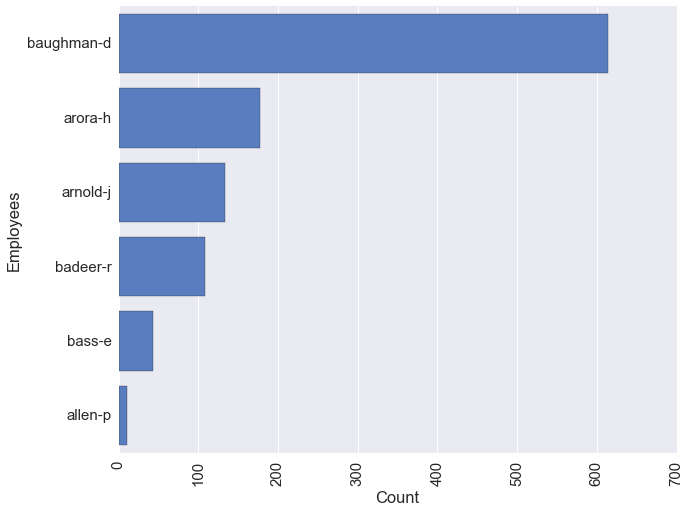

In [1009]:
mail_count = emails["employee"].value_counts()
indices = mail_count.index
count = pd.DataFrame(mail_count)
count.rename(columns = {"employee": "Count"}, inplace = True)
count["Employees"] = indices
barplot(df = count[:30], X = "Count", Y = "Employees", figsize = (10, 8), color = 'b', orient = 'h', ylabel = "Employees", xlabel = "Count", font_scale = 1.5, rotation = 90)

**Figure 2**: Bar graph showing 30 employees who had the highest number of sent e-mails

In figure 2, we see that *kean-s, kaminski-v, kitchen-l, farmer-d, williams-w3* and *lokay-m* had over 2000 e-mails contained within topical folders.  There are a few employees, such as *taylor-m, beck-s, shapiro-r* and *symes-k* who had approximately 2000 e-mails.  The rest of employees had anywhere between 50 - 1800 emails (some not shown).  For this project, I'll use employees that had more than 1000 e-mails in topical folders.   

### Extract e-mails for employees who had over 1000 e-mails

In [588]:
email_count = dict(emails["employee"].value_counts())
reduced_emails = [key for key, val in email_count.items() if val > 1000]
emails = emails.loc[emails['employee'].isin(reduced_emails)]
print emails["employee"].value_counts()

Series([], Name: employee, dtype: int64)


In [735]:
print emails.iloc[:20]["Folder"]

1230           contacts
1231           contacts
3026              straw
3027              straw
3028              straw
3029              straw
3030              straw
3031              straw
3032              straw
3033              straw
3848    2000 conference
3849    2000 conference
3850    2000 conference
4899              avaya
4900              avaya
4901              avaya
4902              avaya
4903              avaya
4904                bmc
4905                bmc
Name: Folder, dtype: object


### Missing Values

We see that the **`X-From`**, **`Folder`**, and **`X-To`** columns contain missing values.  Given that the number of missing values is relatively small compared to the size of the entire dataset, we can go ahead and drop the rows containing these missing values

In [862]:
emails.isnull().sum()

file            0
message         0
Message-Body    0
X-From          4
employee        0
Folder          4
Date            0
Subject         0
X-To            4
dtype: int64

In [867]:
emails.dropna(inplace = True)
print("Rows with missing values have been removed")
emails.isnull().sum()

Rows with missing values have been removed


file            0
message         0
Message-Body    0
X-From          0
employee        0
Folder          0
Date            0
Subject         0
X-To            0
dtype: int64

### Encoding class labels

Our folders in the **`Folders`** column need to be converted into integers so that the learning algorithm can interpret the data correctly.  These folders are categorical and as such, it does not matter which integer is assigned to a particular folder.  Scikit-learn has a [LabelEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) class that can implement this conversion.  The conversion was applied and assigned to **`y`**, which we will use as our preprocessed set of labels

In [896]:
from sklearn.preprocessing import LabelEncoder

class_le = LabelEncoder()
y = class_le.fit_transform(emails['Folder'].values)
emails["y"] = y
print("Randomly selected labels representing our folders")
print(display(emails[["y", "Folder"]].sample(10)))

Randomly selected labels representing our folders


,y,Folder
8483,53,savedmail
19776,1,24 hour
19699,35,jokes
19081,1,24 hour
19214,41,miso
19747,37,letters
8361,52,saved mail
16129,46,personal
9001,7,california
8382,52,saved mail


None


### Bag-of-words model

For the computer to make inferences of the e-mails, it has to be able to interpret the text by making a numerical representation of it.  One way to do this is by using something called a [**Bag-of-words model**](https://en.wikipedia.org/wiki/Bag-of-words_model).  It will take the e-mails as a string and convert it into a numerical vector to show the frequency that each unique word appears over the entire dataset.  

### Tokenization 

Given that we already cleaned the data, the next step involves tokenizing our features. Tokenization involves splitting each text document into a list of words.

In [875]:
def tokenize(row):
    if row is None or row is '':
        tokens = ""
    else:
        tokens = row.split(" ")
    return tokens

### Remove regular expressions

After that, the regular expressions, which includes punctuation marks and nonword characters need to be removed.  I will use Python's regular expression ([regex](https://docs.python.org/2/library/re.html)) libary to remove these characters.

In [876]:
import re

def remove_reg_expressions(row):
    tokens = []
    try:
        for token in row:
            token = token.lower()
            token = re.sub(r'[\W\d]', " ", token)
            tokens.append(token)
    except:
        token = ""
        tokens.append(token)
    return tokens

### Stop-word removal

Stop-words are also removed.  Stop-words are words that are very common in text but offer no useful information that can be used to classify the text.  Words such as *is*, *and*, *the*, *are* are examples of stop-words.  The [NLTK library](http://www.nltk.org) contains a list of 127 English stop-words and can be used to filter our tokenized strings.

In [877]:
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')    

def stop_word_removal(row):
    token = [token for token in row if token not in stopwords]
    token = filter(None, token)
    return token

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/donaldfung/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Assemble matrices

The **`assemble_bag()`** function will call the **`tokenize()`**, **`remove_reg_expressions()`**, **`stop_word_removal()`** functions to clean the data.  Then it assembles a new dataframe containing all the unique words found in the text documents.  It counts the word frequency and then returns the new dataframe.  

In [878]:
def assemble_bag(data):
    data = data.apply(tokenize)
    data = data.apply(stop_word_removal)
    data = data.apply(remove_reg_expressions)
    
    
    unique_tokens = []
    single_tokens = []

    for item in data:
        for token in item:
            if token in single_tokens:
                if token not in unique_tokens:
                    unique_tokens.append(token)
            else:
                single_tokens.append(token)
    
    df = pd.DataFrame(0, index = np.arange(len(data)), columns = unique_tokens)
    
    for i, item in enumerate(data):
        for token in item:
            if token in unique_tokens:
                df.iloc[i][token] += 1    
    return df

## Multiclass Classification using Logistic Regression

In Multiclass classification problems, there exists more than 2 categories or multiple folders.  Let's focus on just one Enron employee for our classification problem.

In [970]:
employee = emails[emails["employee"] == "baughman-d"]
unique_folders = employee["y"].unique()
print(unique_folders)

[13 20  1 10 18 26 28 34 38 39 41 45 47 61 23  9 30 32 33 35 37 57 59]


We call the **`assemble_bag()`** method for each feature to return a new dataframe.  These dataframes are concatenated to a new dataframe called **`X`**.

In [971]:
from_bag = assemble_bag(employee["X-From"])
to_bag = assemble_bag(employee["X-To"])
message_bag = assemble_bag(employee["Message-Body"])
subject_bag = assemble_bag(employee["Subject"])
frames = [from_bag, subject_bag, to_bag, message_bag]
X = pd.concat(frames, axis = 1, join = 'inner')
X.drop(labels = [" ", ""], inplace = True, axis = 1)

In [972]:
print(display(X.ix[:3, 1000:]))
print("A peek into some of the columns in the features dataframe")

,ben,gay,eduardo,gonzalez,jaime,...,password,courtesy,www tradersnewsenergy com bobette,bobette riner ipgdirect com sent,thanks
0,0,0,0,0,0,...,0,0,0,0,0
1,0,0,0,0,0,...,0,0,0,0,0
2,0,0,0,0,0,...,0,0,0,0,0
3,0,0,0,0,0,...,0,0,0,0,0


None
A peek into some of the columns in the features dataframe


In training a multiclass classification problem, we have to train n models where n is the number of unique folders present.  Using a one-vs-all approach, we need to train models where all e-mails belonging to a folder are classified as positive (1) or **True** and all e-mails not belonging to a folder are classified as negative (0) or **False**. 

#### For example:

If folders cinergy index, fundamentals and meetings exists for an employee, then: 
* All the e-mails belonging to cinergy index are positive(1) and all e-mails belonging to other folders are negative(0)
* All the e-mails belonging to fundamentals are positive(1) and all e-mails belonging to other folders are negative(0)
* All the e-mails belonging to miso are positive(1) and all e-mails belonging to other folders are negative(0) 

### Training

In [1002]:
from sklearn.linear_model import LogisticRegression

# split data into training and testing sets
training_size = int(len(employee) * 0.8)
X_train = X[:training_size]
X_test = X[training_size:]
y_test = employee[training_size:]["y"]
models = {}

for folder in unique_folders:
    model = LogisticRegression()
    y_train = employee[:training_size]["y"] == folder
    model.fit(X_train, y_train)
    models[folder] = model

### Testing

In [1013]:
testing_probs = pd.DataFrame(columns = unique_folders)

for folder in unique_folders:
    # Compute probability of observation being in the origin.
    testing_probs[folder] = models[folder].predict_proba(X_test)[:,1]

y_test_pred = testing_probs.idxmax(axis = 1)

### Accuracy Score

In [1014]:
from sklearn.metrics import accuracy_score

score = accuracy_score(y_test, y_test_pred)
print(score)

0.780487804878
